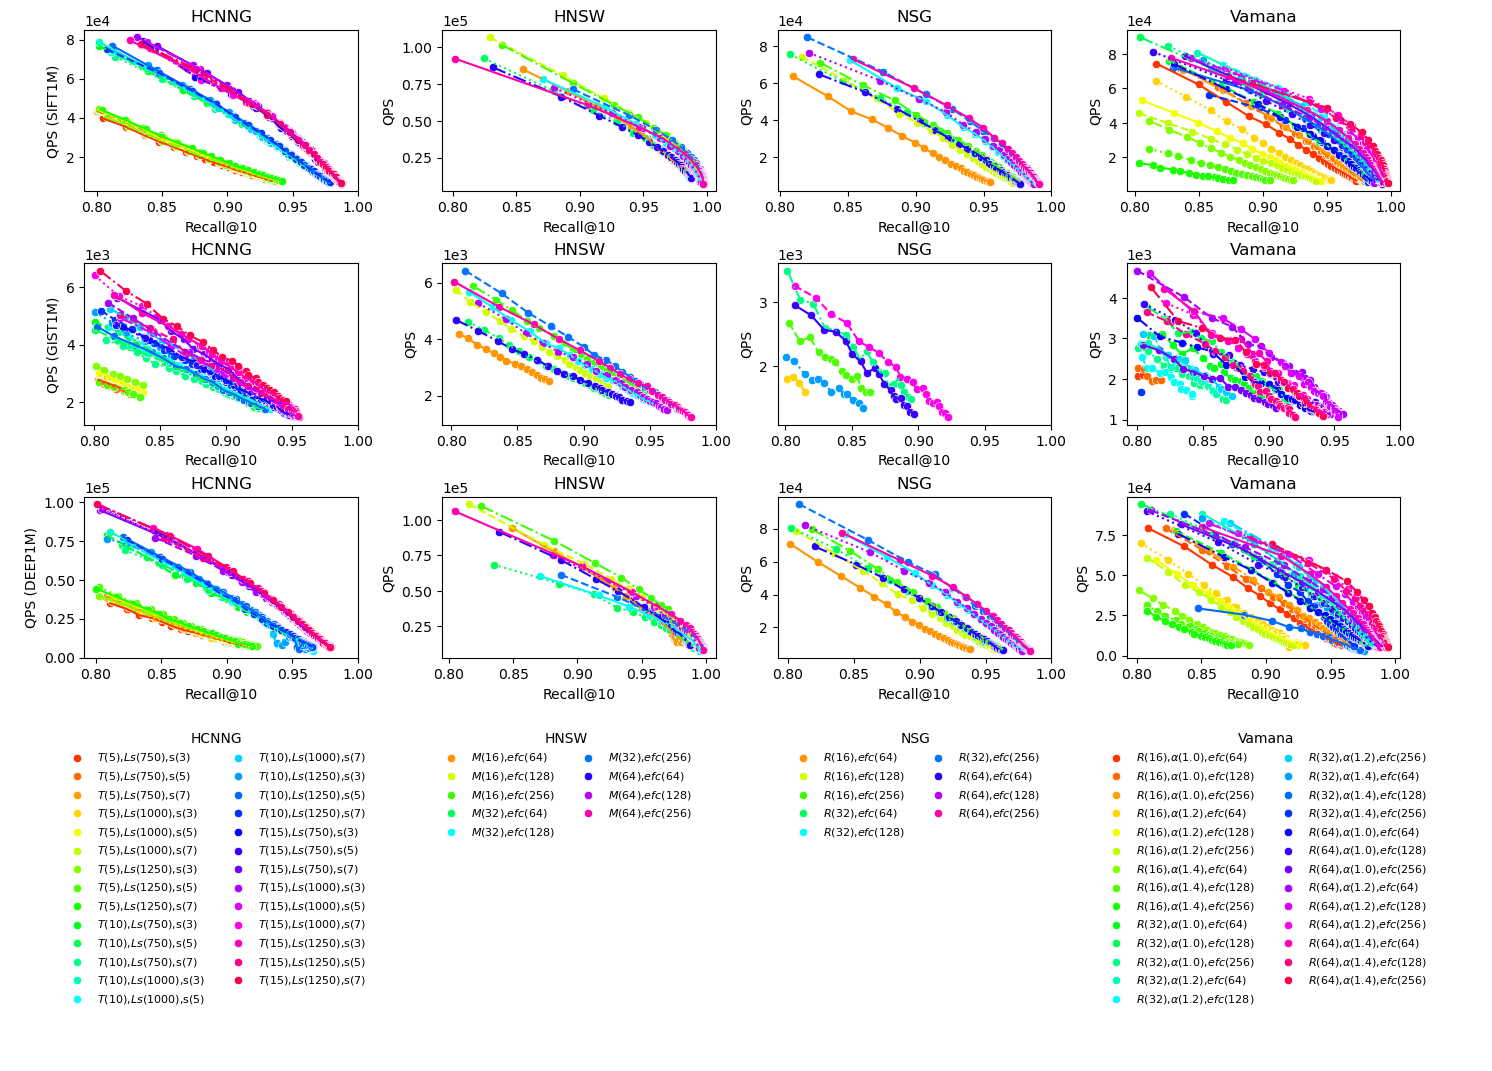

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product

datasets = ['sift1m', 'gist1m', 'deep1m']
indices = ['hcnng', 'hnsw', 'nsg', 'vamana']

params = {
  'vamana': ['max_degree', 'alpha', 'efc'],
  'hcnng': ['num_random_clusters', 'min_size_cluters', 'max_mst_degree'],
  'hnsw': ['max_degree', 'efc'],
  'nsg': ['max_degree', 'efc']
}

fig, axs = plt.subplots(len(datasets), len(indices), figsize=(14, 7), constrained_layout=True)

legend_handles_labels = {index: ([], []) for index in indices}

for d_idx, dataset in enumerate(datasets):
    for i_idx, index in enumerate(indices):
        ax = axs[d_idx, i_idx]
        df = pd.read_csv(f'{dataset}_{index}.csv')
        df = df[df['recall'] > 0.8]
        df['QPS'] = df['num_queries'] / df['query_time']
        index_params = params[index]
        param_combinations = list(product(*[df[param].unique() for param in index_params]))
        colors = sns.color_palette("hsv", len(param_combinations))
        linestyles = ['-', '--', '-.', ':']
        style_combinations = [(color, linestyle) for color, linestyle in zip(colors, linestyles * (len(param_combinations) // len(linestyles) + 1))]
        for param_values, (color, linestyle) in zip(param_combinations, style_combinations):
            mask = np.ones(len(df), dtype=bool)
            for param, value in zip(index_params, param_values):
                mask &= (df[param] == value)
            
            subset = df[mask]

            if subset.empty:
                continue

            if index == 'hnsw':
              lnames = [r'$M$', r'$efc$']
            elif index == 'hcnng':
              lnames = [r'$T$', r'$Ls$', r's']
            elif index == 'vamana':
              lnames = [r'$R$', r'$\alpha$', r'$efc$']
            else:
              lnames = [r'$R$', r'$efc$']
            

            label = ','.join([f'{param}({value})' for param, value in zip(lnames, param_values)])
            
            sns.lineplot(data=subset, x='recall', y='QPS', ax=ax, color=color, linestyle=linestyle, legend=False)
            scatter = sns.scatterplot(data=subset, x='recall', y='QPS', color=color, label=label, ax=ax)
            
            handles, labels = scatter.get_legend_handles_labels()
            for handle, label in zip(handles, labels):
                if label not in legend_handles_labels[index][1]:
                    legend_handles_labels[index][0].append(handle)
                    legend_handles_labels[index][1].append(label)

        ax.set_title(f'{index.upper() if index != 'vamana' else 'Vamana'}')
        ax.set_xlabel('Recall@10')
        if i_idx == 0:
          ax.set_ylabel(f'QPS ({dataset.upper()})')
        else:
          ax.set_ylabel('QPS')
        ax.set_xticks(np.arange(0.8, 1.001, 0.05))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.legend().remove()

for i, index in enumerate(indices):
  if index in legend_handles_labels:
    handles, labels = legend_handles_labels[index]
    fig.legend(handles, labels, title=(index.upper() if index != 'vamana' else 'Vamana'), 
      bbox_to_anchor=(0.14 + i * 0.25, 0.05), loc='upper center', ncol=2, prop={'size': 8},
      borderpad=5, frameon=False)

plt.savefig('optimal_parameters.png', dpi=600, bbox_inches='tight')
plt.savefig('optimal_parameters.svg', dpi=1200, bbox_inches='tight')
plt.savefig('optimal_parameters.pdf', dpi=1200, bbox_inches='tight')
plt.show()
